In [61]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division
from mhcflurry import predict
from mhcflurry import class1_allele_specific
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve

In [3]:
filepath = "./data/immunogenic_peptides.txt"
if os.path.isfile(filepath):
    df = pd.read_csv(filepath, sep="\t")
    print("Reading {}".format(os.path.basename(filepath)))
else:
    print("File path is wrong")

Reading immunogenic_peptides.txt


In [4]:
df.head(2)

,Peptide,MHC,Species,Immunogenicity
0,AAFDRKSDAK,HLA-A1101,Homo,immunogenic
1,AAFEFINSL,H-2-Kb,Mus,immunogenic


In [5]:
df["Immunogenicity"].value_counts()

immunogenic        2167
non-immunogenic     341
Name: Immunogenicity, dtype: int64

In [6]:
predict(alleles=df["MHC"].iloc[0:1], peptides=df["Peptide"].iloc[0:10]).head(2)

/home/vasily/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/gradients.py:90: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


,Allele,Peptide,Prediction
0,HLA-A1101,AAFDRKSDAK,367.609009
1,HLA-A1101,AAFEFINSL,6281.542969


In [8]:
predictions = pd.DataFrame()
warning = pd.DataFrame()
warnings = 0
warning_loc = []
for i in range(len(df)):
    try:
        prediction = predict(alleles=df["MHC"].iloc[i:i+1].reset_index(drop=True),
                                   peptides=df["Peptide"].iloc[i:i+1].reset_index(drop=True))
        frame = [predictions, prediction]
        predictions = pd.concat(frame)
    except ValueError:
        warnings += 1
        frame = [warning, df.iloc[i]]
        warning = pd.concat(frame)
        warning_loc.append(i)
if len(predictions):
    print("Predictions made")
else:
    print("Something went wrong")
print("Number of warnings is {}".format(warnings))
print(warning)

Predictions made
Number of warnings is 1
                          0
Peptide           NIRQAGVQY
MHC               HLA-B1502
Species                Homo
Immunogenicity  immunogenic


In [36]:
predictions.head(5)

,Allele,Peptide,Prediction
0,HLA-A1101,AAFDRKSDAK,367.609009
0,H-2-KB,AAFEFINSL,4.883403
0,HLA-B0801,AAHARFVAA,50.025242
0,H-2-DB,AAIGNMTLL,18.478685
0,H-2-DB,AAITIATPI,237.135406


In [10]:
def coding(col, codeDict):
    colCoded = pd.Series(col, copy=True)
    for key, value in codeDict.items():
        colCoded.replace(key, value, inplace=True)
    return colCoded

In [11]:
true_values = coding(df["Immunogenicity"], {"immunogenic":1, "non-immunogenic":0})
true_values = pd.DataFrame(true_values)
true_values.index = range(1,len(true_values) + 1)
true_values.drop(true_values.index[warning_loc], inplace=True)
true_values["Immunogenicity"].value_counts()

1    2166
0     341
Name: Immunogenicity, dtype: int64

In [37]:
sorted_predictions = predictions["Prediction"].sort_values()
sorted_predictions.head(2)

754     1.334695
1694    1.419618
Name: Prediction, dtype: float64

<function matplotlib.pyplot.show>

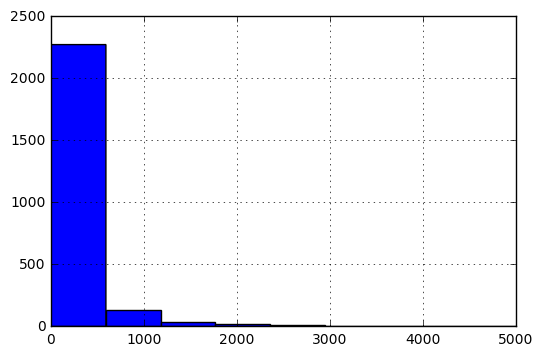

In [40]:
sorted_predictions.index = range(1,len(sorted_predictions) + 1)
plt.figure()
#plt.plot(sorted_predictions.index, sorted_predictions.values)
plot = sorted_predictions.hist(bins=50)
plot.set_xlim([0,5000])
plt.show

In [43]:
#sorted_predictions.columns = ["Prediction"]
#sorted_predictions = pd.DataFrame(sorted_predictions)
predicted_values = predictions["Prediction"]
predicted_values.index = range(1,len(predicted_values) + 1)
predicted_values.columns = ["Prediction"]
predicted_values = pd.DataFrame(predicted_values)
predicted_values["Prediction"] = np.where(predicted_values["Prediction"] <= 500, 1, 0)
predicted_values["Prediction"].value_counts()

1    2218
0     289
Name: Prediction, dtype: int64

In [44]:
accuracy_score(true_values, predicted_values)

0.8165137614678899

In [45]:
roc_auc_score(true_values, predicted_values)

0.57754201834266172

In [46]:
confusion_matrix(true_values, predicted_values)

array([[  85,  256],
       [ 204, 1962]])

In [67]:
i = 0
probabilities = []
for x, y in zip(true_values["Immunogenicity"], predicted_values["Prediction"]):
    if x == y:
        i += 1
    probabilities.append(i/len(true_values))

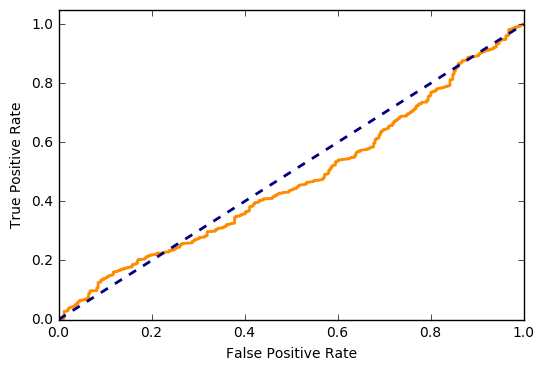

In [68]:
fpr, tpr, thresholds = roc_curve(true_values, probabilities, pos_label=1)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()